# Movie_Sentiment_Analysis

https://web.stanford.edu/class/cs124/lec/sentimentvideoslides2019.pdf

In [119]:
import requests

headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537'}


def getDownload(url, param = None, retries = 3):
    resp = None
    try:
        resp = requests.get(url, params = param, headers = headers)
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        if 500 <= resp.status_code < 600 and retries > 0:
            print('Retries : {0}'.format(retries))
            return getDownload(url, param, retries -1)
        else:
            print(resp.status_code)
            print(resp.reason)
            print(resp.request.headers)
            
    return resp

In [120]:
from bs4 import BeautifulSoup

In [269]:
url = 'https://movie.naver.com/movie/point/af/list.nhn?'
params = {'page':}

In [270]:
html = getDownload(url,params)
dom = BeautifulSoup(html.text,'html.parser')

In [275]:
import tqdm

In [280]:
starList = list()
titleList = list()
reviewList = list()
movie = list()

for n in tqdm.tqdm_notebook(range(1,1001)):
    url = 'https://movie.naver.com/movie/point/af/list.nhn?'
    params = {'page':n}
    html = getDownload(url,params)
    dom = BeautifulSoup(html.text,'html.parser')
    # 평점 가져오기
    for tag in tqdm.tqdm_notebook(dom.select('.list_netizen .point')):
        starList.append(tag.text)
    
    # 제목, 리뷰 가져와서 split
    for tag in tqdm.tqdm_notebook(dom.select('table tbody tr .title')):
        txt = tag.text.strip()
        movie.append(txt)

In [282]:
for i in range(len(movie)):
    t = movie[i].split('\n')[0]
    r = movie[i].split('\n')[1]
    titleList.append(t)
    reviewList.append(r)

In [287]:
len(starList),len(titleList),len(reviewList)

(10000, 10000, 10000)

In [335]:
a = '어벤져스 앤드게임이, 마지막이라니, 뭔가 그리울것 같네요! ㅠㅠ '

In [336]:
from string import punctuation
a.translate(str.maketrans('', '', punctuation))

'어벤져스 앤드게임이 마지막이라니 뭔가 그리울것 같네요 ㅠㅠ '

In [484]:
import re
def getCleanText(item):
    return re.sub(r"[\s]{2,}"," ",item.replace('',''," "))

In [312]:
# csv 만들기 위해 콤마 제거 
reviewSub = list()
from string import punctuation
for t in reviewList:
    tsub = t.translate(str.maketrans('', '', punctuation))
    reviewSub.append(tsub)

In [317]:
movieDF = pd.DataFrame({"Star":starList, "Title":titleList, "Review":reviewSub})

In [318]:
pwd

'/Users/charming/Python/3_Koipa_AI_Learning/NLP'

In [ ]:
# CSV 저장
# movieDF.to_csv('movie_review.csv',sep=',',mode='w')

In [719]:
# index_col = 0으로 설정해야 unnamed가 사라짐
data = pd.read_csv('movie_review.csv',sep=',')
del data['Unnamed: 0']
data = data[data['Review'].notnull()]

In [720]:
len(data)

10000

In [721]:
data.head()

,Star,Title,Review
0,10,어벤져스: 엔드게임,어벤져스 앤드게임이 마지막이라니 뭔가 그리울것 같네요 ㅠㅠ
1,10,어벤져스: 엔드게임,아마블 정말
2,10,어벤져스: 엔드게임,진짜 추억이 주마등처럼 지나가면서 마지막전투신때는 진짜 온몸에 소름이돋아서 눈물까지...
3,10,어벤져스: 엔드게임,영화관에서 안보시면 후회합니다 아이맥스관 강추
4,10,어벤져스: 엔드게임,최고최고최고 눈물 감동 멋짐 모든게 완벽


In [534]:
data.count()

Star      10000
Title     10000
Review    10000
dtype: int64

In [473]:
# 10점이 너무 많아서 10점 빼고 분석할 것!
data.groupby('Star').count()

,Title,Review
Star,,
1,707,707
2,297,297
3,66,66
4,160,160
5,136,136
6,456,456
7,292,292
8,904,904
9,495,495


In [622]:
upperbound = 7
lowerbound = 3

data = data[data['Star'] < 10]
positive = data[data['Star'] > upperbound]
negative = data[data['Star'] <= lowerbound]

In [623]:
len(positive),len(negative)

(1399, 1070)

In [590]:
from collections import defaultdict, Counter
from konlpy.tag import Komoran,Kkma

positiveDTM = defaultdict(Counter)
# pos 1 => {"형태소/품사" = 횟수,"형태소/품사" = 횟수,"형태소/품사" = 횟수,...}
negativeDTM = defaultdict(Counter)
# neg 1 => {"형태소/품사" = 횟수,"형태소/품사" = 횟수,"형태소/품사" = 횟수,...}

ma = Komoran()

for i, review in enumerate(positive['Review']):
    posList = ma.pos(review)
    
    for term in posList:
        if len(term[0]) > 1:
            positiveDTM[i]["/".join(term)] += 1 # 형태소/품사
            


In [624]:
try:
    for i, review in enumerate(negative['Review']):
        posList = ma.pos(review)

        for term in posList:
            if len(term[0]) > 1:
                negativeDTM[i]["/".join(term)] += 1
except:
    print('Null.')

Null.


In [625]:
len(negativeDTM),len(positiveDTM)

(552, 1397)

In [626]:
positiveTDM = defaultdict(Counter)
negativeTDM = defaultdict(Counter)

for i, termList in positiveDTM.items():
    for term,freq in termList.items():
        positiveTDM[term][i] = freq

for i, termList in negativeDTM.items():
    for term,freq in termList.items():
        negativeTDM[term][i] = freq

In [627]:
positiveLexicon = list(set(positiveTDM.keys()))
negativeLexicon = list(set(positiveTDM.keys()))

positiveDocuments = list(positiveDTM.keys())
negativeDocuments = list(positiveDTM.keys())

In [628]:
positivePOS = defaultdict(Counter)
negativePOS = defaultdict(Counter)

for term in positiveLexicon:
    tokens = term.split("/")
    # 형태소/품사 -> tokens[0]: 형태소 (어/벤/져/스) [1] : 품사 
    # TDM[term] -> 어느 문서에서 몇 번
    positivePOS[tokens[-1]][tokens[0]] += sum(positiveTDM[term].values())# 같은 단어일 수 도 있어서 합침
    # 명사 -> 단어1 : positive 내 전체 등장횟수, 단어2:,단어3:
    
for term in negativeLexicon:
    tokens = term.split('/')
    
    negativePOS[tokens[-1]][tokens[0]] += sum(negativeTDM[term].values())  

In [629]:
positivePOS.keys()

dict_keys(['NNG', 'SN', 'NNP', 'VV', 'EC', 'NA', 'MAG', 'XR', 'MM', 'VA', 'JKB', 'SL', 'IC', 'NR', 'MAJ', 'NNB', 'NP', 'VX', 'XSN', 'JX', 'ETM', 'JKS', 'EP', 'XSV', 'VCN', 'SW', 'XSA', 'ETN', 'JC'])

In [630]:
# 보통 명사
positivePOS['NNG'].most_common()[:20]

[('영화', 346),
 ('생각', 101),
 ('기대', 79),
 ('마지막', 76),
 ('연기', 66),
 ('사람', 44),
 ('감동', 41),
 ('내용', 40),
 ('느낌', 36),
 ('마무리', 34),
 ('엄마', 33),
 ('사랑', 32),
 ('장면', 32),
 ('마음', 30),
 ('결말', 29),
 ('작품', 28),
 ('최고', 27),
 ('이해', 27),
 ('부분', 27),
 ('재미', 26)]

In [631]:
negativePOS["NNG"].most_common()[:20]


[('영화', 477),
 ('평점', 126),
 ('시간', 88),
 ('생각', 64),
 ('사람', 60),
 ('내용', 59),
 ('여자', 54),
 ('기대', 47),
 ('수준', 39),
 ('개연', 39),
 ('감독', 33),
 ('느낌', 32),
 ('감동', 31),
 ('처음', 30),
 ('제일', 27),
 ('마지막', 26),
 ('진짜', 22),
 ('이상', 22),
 ('연기', 21),
 ('현실', 21)]

In [632]:
Komoran().tagset

{'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ETM': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JKB': '부사격 조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JKV': '호격 조사',
 'JX': '보조사',
 'MAG': '일반 부사',
 'MAJ': '접속 부사',
 'MM': '관형사',
 'NA': '분석불능범주',
 'NF': '명사추정범주',
 'NNB': '의존 명사',
 'NNG': '일반 명사',
 'NNP': '고유 명사',
 'NP': '대명사',
 'NR': '수사',
 'NV': '용언추정범주',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SH': '한자',
 'SL': '외국어',
 'SN': '숫자',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'VA': '형용사',
 'VCN': '부정 지정사',
 'VCP': '긍정 지정사',
 'VV': '동사',
 'VX': '보조 용언',
 'XPN': '체언 접두사',
 'XR': '어근',
 'XSA': '형용사 파생 접미사',
 'XSN': '명사파생 접미사',
 'XSV': '동사 파생 접미사'}

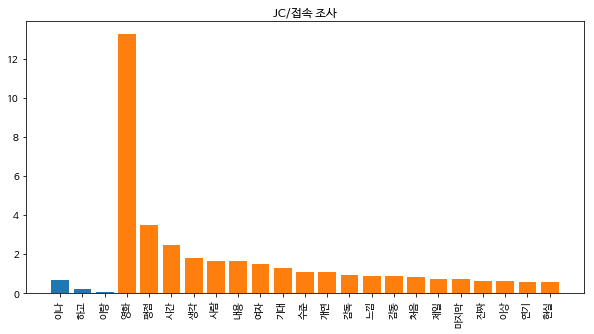

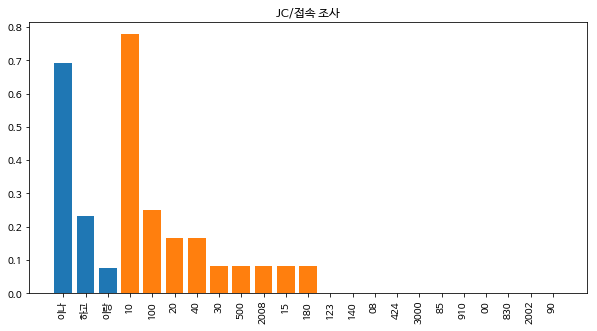

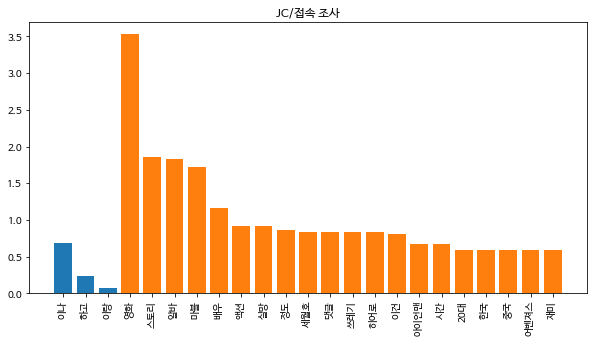

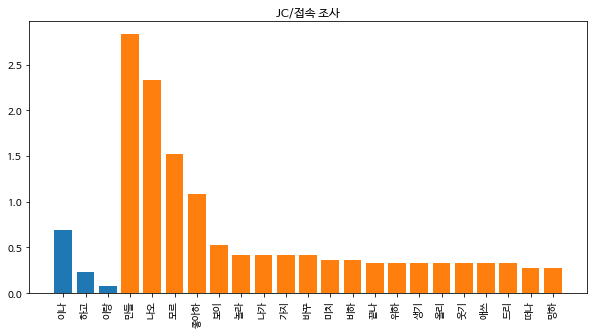

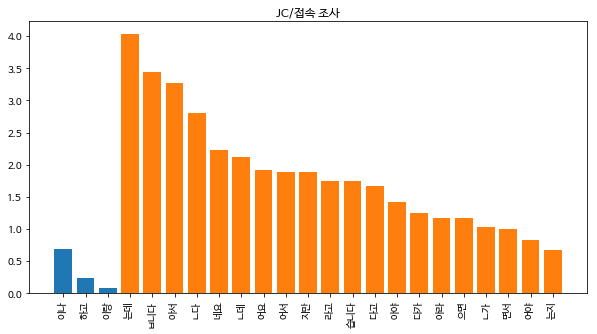

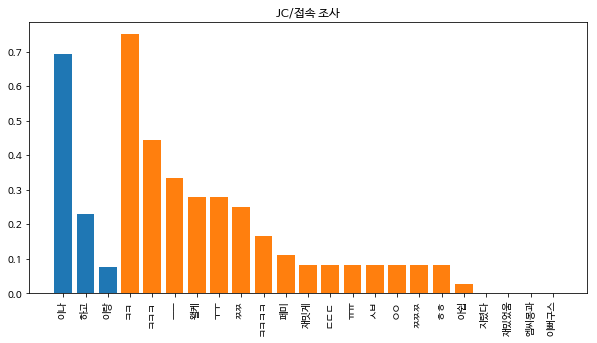

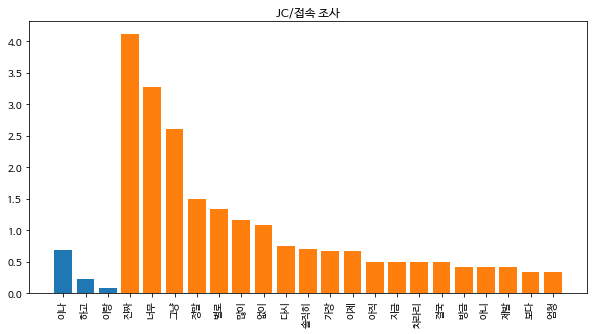

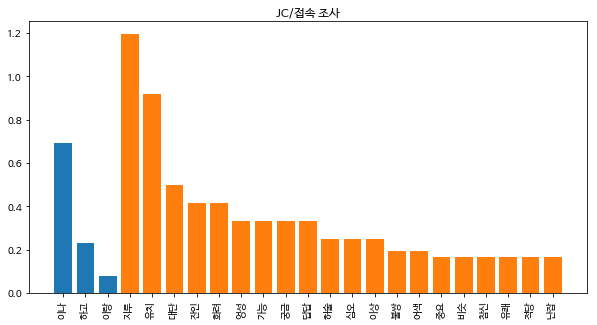

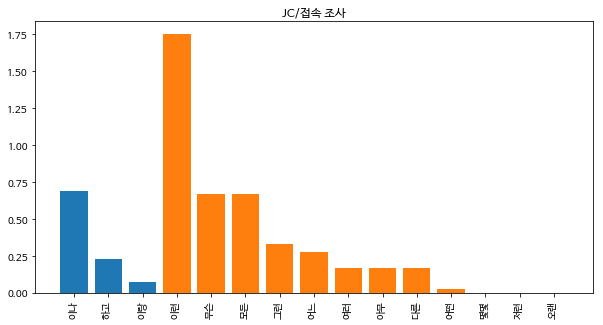

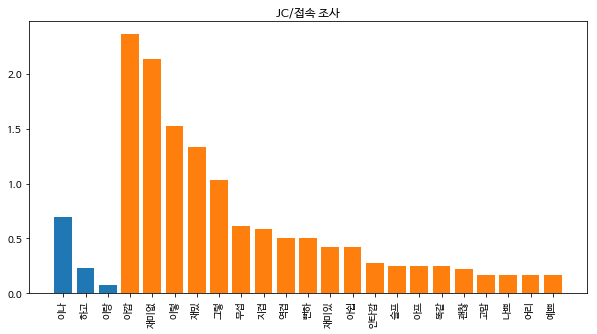

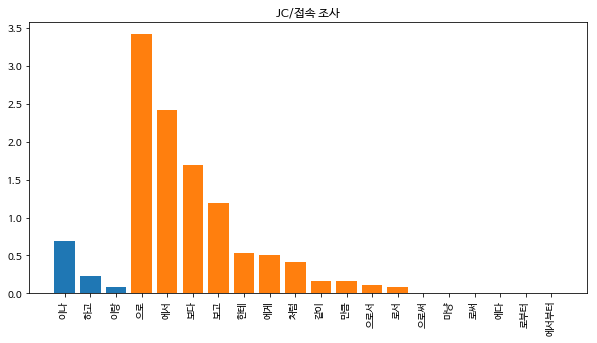

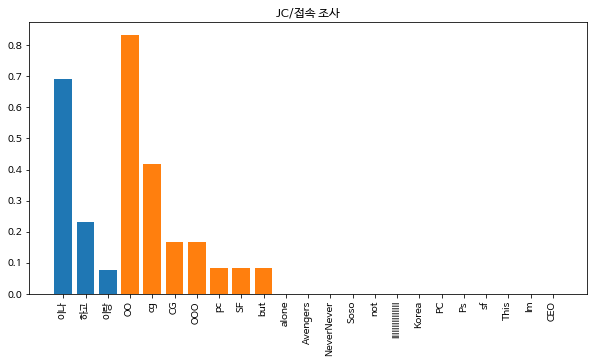

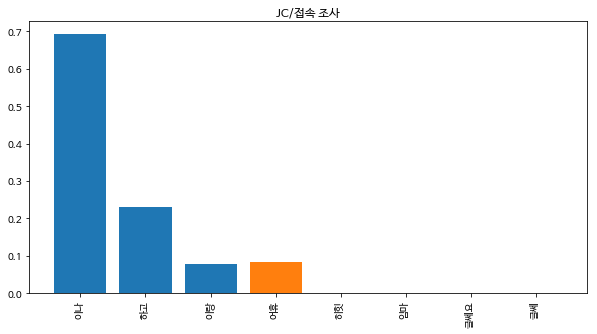

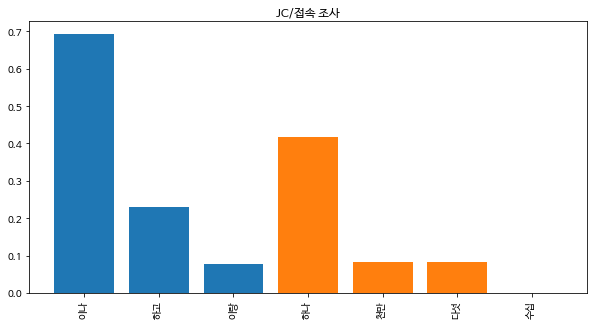

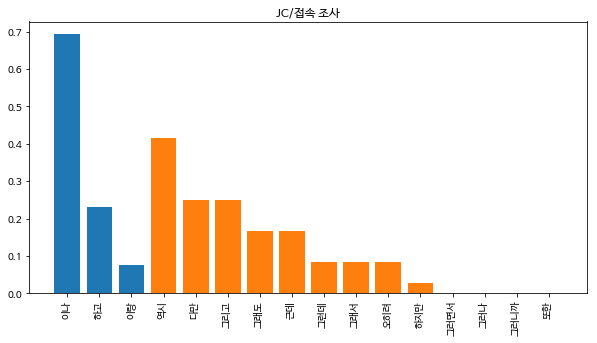

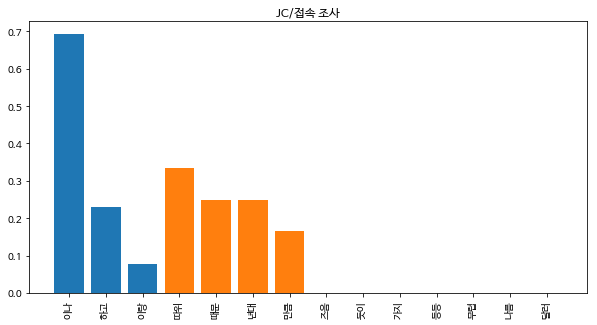

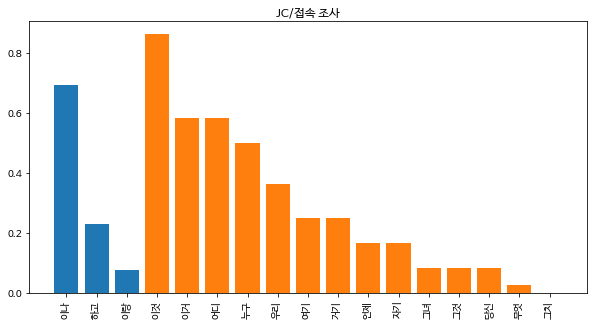

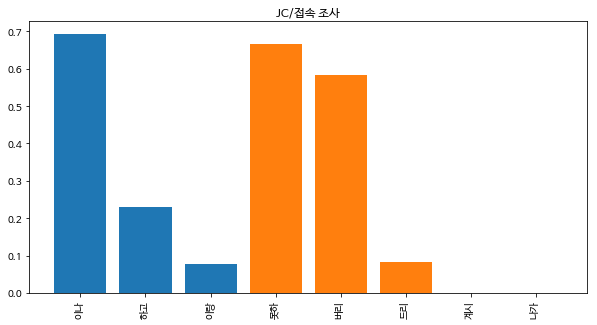

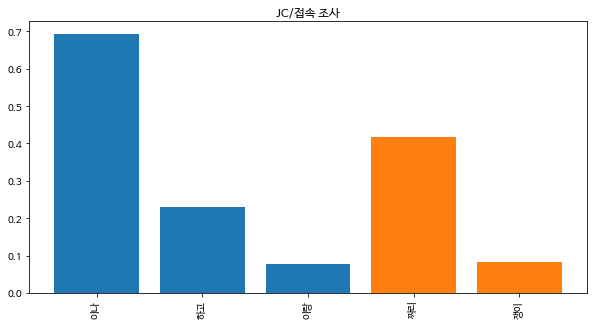

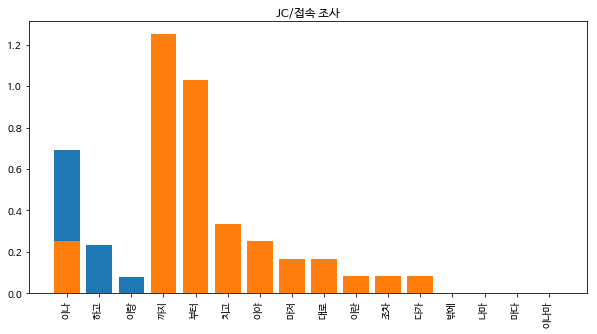

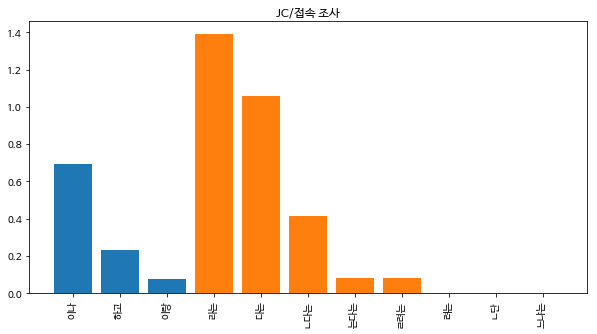

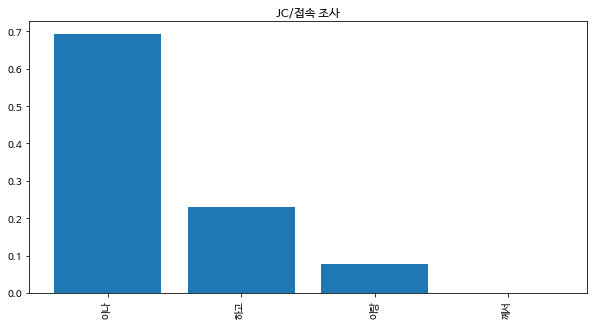

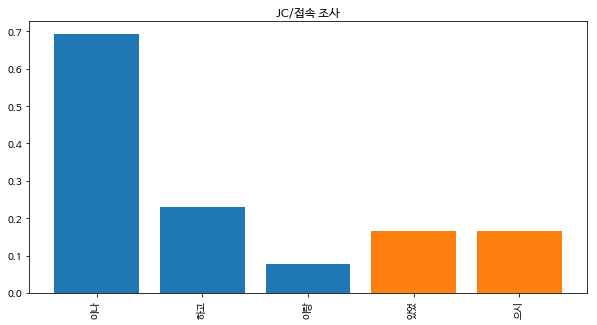

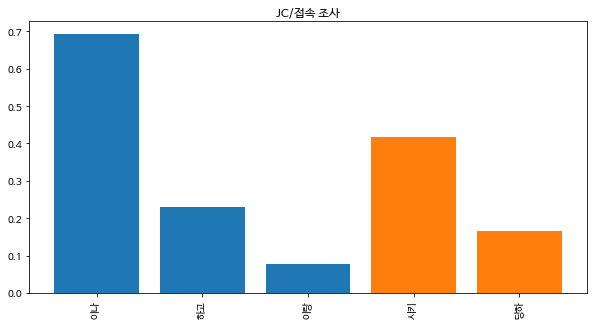

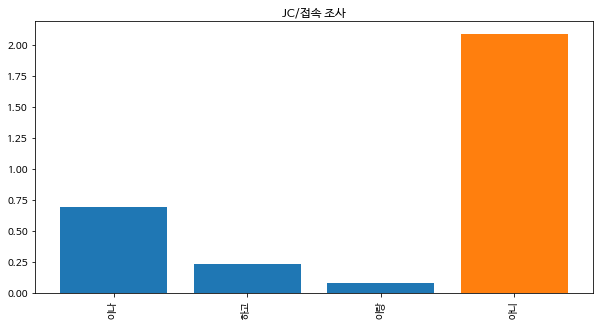

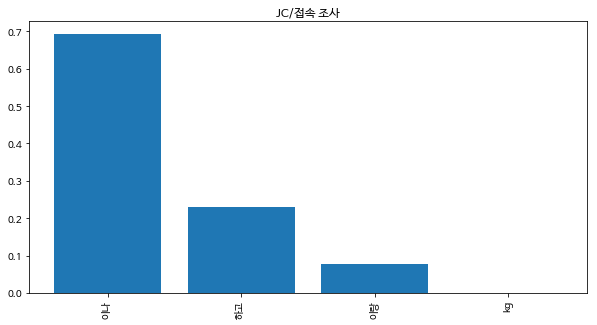

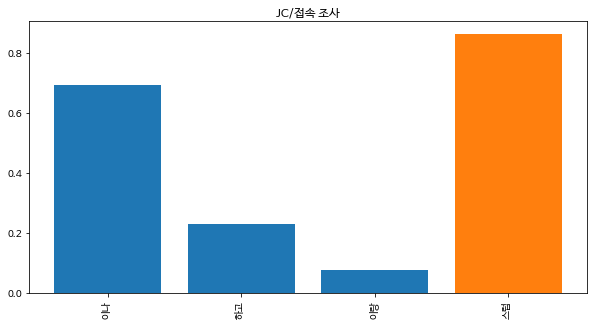

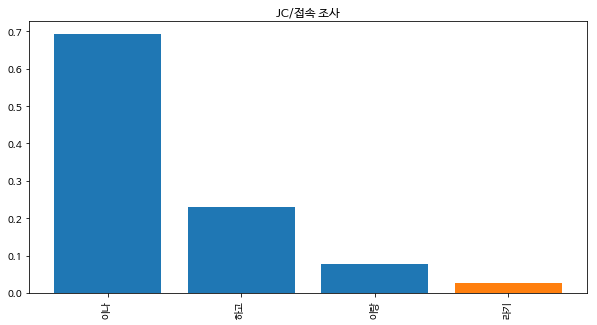

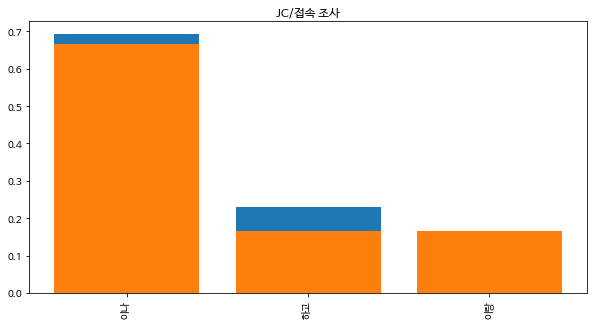

In [675]:
from konlpy.tag import Komoran
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

tagList = Komoran().tagset

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

rc("figure", figsize=(10,5))

for posName in positivePOS.keys():
    pNorm = sum(positivePOS[posName].values())
    pTermList = [pair[0] for pair in positivePOS[posName].most_common()[:20]]
    pFreqList = [pair[1]/pNorm for pair in positivePOS[posName].most_common()[:20]]

for negName in negativePOS.keys():
    nNorm = sum(negativePOS[posName].values())
    nTermList = [pair[0] for pair in negativePOS[negName].most_common()[:20]]
    nFreqList = [pair[1]/nNorm for pair in negativePOS[negName].most_common()[:20]]
    
    plt.title("{0}/{1}".format(posName, tagList[posName]))
    plt.bar(pTermList, pFreqList, align="center")
    plt.bar(nTermList, nFreqList, align="center")
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# PMI는 correlation이고 이를 가지 SO를 통해 값을 얻어서 Pos / Neg 의미 판단 
# SO = Pos(PMI(term,y)) - Neg(PMI(term,y))
# +,-는 Strength가 됨 
# 다 하고 
# pSeed = ["재밌"]
# nSeed = ["지루"] 라고 해놓고 DTM, TDM 으로 하나로 합쳐줌  
# positivem negative 신경쓰지 말기

In [664]:
from math import log

K = 0.1
N = len(positiveDTM) + len(negativeDTM)

positivePMI = defaultdict(float)
positiveNPMI = defaultdict(float)

seedDocList = list(positiveDTM.keys())
seedLikelihood = len(seedDocList)/N

for term in list(set(positiveLexicon + negativeLexicon)):
    termDocList = list(positiveTDM[term].keys()) + list(negativeTDM[term].keys())
    termLikelihood = len(termDocList)/N

    jointLikelihood = (len(positiveTDM[term].keys()) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    positivePMI[term] = log(jointLikelihood/multiLikelihood)
    positiveNPMI[term] = positivePMI[term]/-log(jointLikelihood)

In [665]:
negativePMI = defaultdict(float)
negativeNPMI = defaultdict(float)

seedDocList = list(negativeDTM.keys())
seedLikelihood = len(seedDocList)/N

for term in list(set(positiveLexicon + negativeLexicon)):
    termDocList = list(positiveTDM[term].keys()) + list(negativeTDM[term].keys())
    termLikelihood = (len(termDocList) + K)/N

    jointLikelihood = (len(negativeTDM[term].keys()) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    negativePMI[term] = log(jointLikelihood/multiLikelihood)
    negativeNPMI[term] = negativePMI[term]/-log(jointLikelihood)

In [666]:
pmiSO = defaultdict(float)
invertedPmiSO = defaultdict(float)

npmiSO = defaultdict(float)
invertedNpmiSO = defaultdict(float)

for term in list(set(positiveLexicon + negativeLexicon)):
    pmiSO[term.split("/")[0]] += positivePMI[term] - negativePMI[term]
    invertedPmiSO[term.split("/")[0]] -= positivePMI[term] - negativePMI[term]
    
    npmiSO[term.split("/")[0]] += positiveNPMI[term] - negativeNPMI[term]
    invertedNpmiSO[term.split("/")[0]] -= positiveNPMI[term] - negativeNPMI[term]

In [667]:
print(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:10])

print(sorted(npmiSO.items(), key=lambda x:x[1], reverse=True)[:10])

print(sorted(pmiSO.items(), key=lambda x:x[1], reverse=False)[:10])

print(sorted(npmiSO.items(), key=lambda x:x[1], reverse=False)[:10])

[('엄마', 7.7003753168218), ('약간', 7.118484013594365), ('정리', 6.403105396038381), ('매력', 6.008599219459469), ('마다', 5.758153318636557), ('부모', 5.643115650604118), ('아들', 5.643115650604118), ('만족', 5.363647142057644), ('후반', 5.347973080643084), ('오락', 5.347973080643084)]
[('엄마', 0.8478547457334019), ('약간', 0.7797774727019152), ('정리', 0.6993319703961542), ('매력', 0.6553418184624652), ('마다', 0.6294433564949334), ('조금', 0.6287747325552835), ('부모', 0.6165475070295834), ('아들', 0.6165475070295834), ('만족', 0.5854532045612443), ('후반', 0.5829714843229106)]
[('이나', -5.29191739070909), ('손가락', -4.448816959179248), ('진짜', -4.164465334748933), ('아깝', -4.078497138565631), ('실망', -3.877677088794451), ('시키', -3.8724857868517892), ('알바', -3.7702617111830548), ('우주', -3.4823052871581988), ('유치', -3.4607731129514017), ('언제', -3.4183430197966955)]
[('진짜', -0.9153335251217402), ('이나', -0.826453985875708), ('아깝', -0.7499416244615071), ('알바', -0.6777841190274438), ('실망', -0.662339358974972), ('손가락', -0.654322067

In [700]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fontPath = "/Library/Fonts/AppleGothic.ttf"
def drawCloud(words):
    wc = WordCloud(font_path=fontPath, max_words=30, background_color="white")
    wc.generate_from_frequencies(words)
    return wc.to_image()


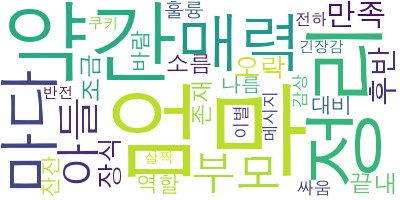

In [703]:
# Positive
drawCloud(dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:30]))

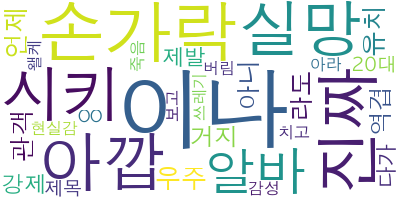

In [704]:
# Negative
drawCloud(dict(sorted(invertedPmiSO.items(), key=lambda x:x[1], reverse=True)[:30]))

# SO

In [722]:
data

,Star,Title,Review
0,10,어벤져스: 엔드게임,어벤져스 앤드게임이 마지막이라니 뭔가 그리울것 같네요 ㅠㅠ
1,10,어벤져스: 엔드게임,아마블 정말
2,10,어벤져스: 엔드게임,진짜 추억이 주마등처럼 지나가면서 마지막전투신때는 진짜 온몸에 소름이돋아서 눈물까지...
3,10,어벤져스: 엔드게임,영화관에서 안보시면 후회합니다 아이맥스관 강추
4,10,어벤져스: 엔드게임,최고최고최고 눈물 감동 멋짐 모든게 완벽
5,10,어벤져스: 엔드게임,한타타이밍오지구요 ㅋㅋ 아이언맨
6,10,노무현과 바보들,노짱 그립습니다
7,10,어벤져스: 엔드게임,존잼 ㅜㅠㅠㅠ 허리랑 엉덩이는 아프지만 눈물도 나고 역시 마블이네요 ㅠㅠ
8,10,어벤져스: 엔드게임,3000만큼 사랑한다 진심
9,10,어벤져스: 엔드게임,마블의 역사는 아이언맨으로 시작해 아이언맨으로 끝이났다


In [729]:
pSeed = ['재밌']
nSeed = ["지루"]

from collections import defaultdict, Counter
from konlpy.tag import Komoran,Kkma

DTM = defaultdict(Counter)

ma = Komoran()

try:
    for j in range(0,10):
        for i, review in enumerate(data[j:(j+1)*1000]['Review']):
            posList = ma.morphs(review)

            for term in posList:
                if len(term[0]) > 1:
                    DTM[i][term] += 1 # 형태소/품사
except:
    print('null')
            



java.lang.OutOfMemoryErrorPyRaisable: java.lang.OutOfMemoryError: Java heap space

In [724]:
TDM = defaultdict(Counter)

for i, termList in DTM.items():
    for term,freq in termList.items():
        TDM[term][i] = freq

In [725]:
Lexicon = list(TDM.keys())

In [726]:
N

0

In [715]:
from math import log

K = 0.1
N = len(DTM)

pPMI = defaultdict(float)
pNPMI = defaultdict(float)

seedDocList = list(TDM[pSeed[0]].keys())
seedLikelihood = len(seedDocList)/N
try:
    for term in Lexicon:
        termDocList = list(TDM[term].keys())
        termLikelihood = len(termDocList)/N

        jointLikelihood = (len(set(seedDocList).intersection(termDocList)) + K)/N
        multiLikelihood = seedLikelihood * termLikelihood

        pPMI[term] = log(jointLikelihood/multiLikelihood)
        pNPMI[term] = pPMI[term]/-log(jointLikelihood)
except:
    print('no')


ZeroDivisionError: division by zero

In [716]:
from math import log

K = 0.1
N = len(DTM)

nPMI = defaultdict(float)
nNPMI = defaultdict(float)

seedDocList = list(TDM[nSeed[0]].keys())
seedLikelihood = len(seedDocList)/N

for term in Lexicon:
    termDocList = list(TDM[term].keys())
    termLikelihood = len(termDocList)/N

    jointLikelihood = (len(set(seedDocList).intersection(termDocList)) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    nPMI[term] = log(jointLikelihood/multiLikelihood)
    nNPMI[term] = pPMI[term]/-log(jointLikelihood)

ZeroDivisionError: division by zero

In [ ]:
SO = defaultdict(float)
iSO = defaultdict(float)

_SO = defaultdict(float)
_iSO = defaultdict(float)

for term in TDM.keys():
    SO[term] += pPMI[term] - nPMI[term]
    iSO[term] -= pPMI[term] - nPMI[term]
    
    _SO[term] += pNPMI[term] - nNPMI[term]
    _iSO[term] -= pNPMI[term] - nNPMI[term]

In [ ]:
print(sorted(SO.items(), key=lambda x:x[1], reverse=True)[:10])

print(sorted(iSO.items(), key=lambda x:x[1], reverse=True)[:10])

print(sorted(_SO.items(), key=lambda x:x[1], reverse=False)[:10])

print(sorted(_iSO.items(), key=lambda x:x[1], reverse=False)[:10])